## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **OLD DATASET LOADER**

In [2]:
# # Loading CIFAR 100 dataset
# def CIFAR100DataLoader(
#     split, batch_size=8, num_workers=2, shuffle=True, size="32", normalize="standard"
# ):
#     """
#     A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
#     the parameters supplied and applies the required data augmentations.

#     Args:
#         split: A string to decide if train or test data to be used (Values: 'train', 'test')
#         batch_size: Batch size to used for loading data (Default=8)
#         num_workers: Number of parallel workers used to load data (Default=2)
#         shuffle: Boolean value to decide if data should be randomized (Default=True)
#         size: A string to decide the size of the input images (Default='32') (Values: '32','224')
#         normalize: A string to decide the normalization to applied to the input images
#                    (Default='standard') (Values: 'standard', 'imagenet')

#     Output:
#         DataLoader Object
#     """
#     if normalize == "imagenet":
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#     elif normalize == "standard":
#         mean = [0.5, 0.5, 0.5]
#         std = [0.5, 0.5, 0.5]

#     if split == "train":
#         if size == "224":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )
#         elif size == "32":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomCrop(32, padding=4),
#                     transforms.RandomHorizontalFlip(),
#                     transforms.RandomRotation(15),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="data", train=True, download=True, transform=train_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     elif split == "test":
#         if size == "224":
#             test_transform = transforms.Compose(
#                 [
#                     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         elif size == "32":
#             test_transform = transforms.Compose(
#                 [transforms.ToTensor(), transforms.Normalize(mean, std)]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="./data", train=False, download=True, transform=test_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     return dataloader

## **NEW DATASET LOADER**

In [3]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [4]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [5]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [6]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [7]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0
    index = 0
    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [8]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 384

layers = 12
heads = 12

resnet_features_channels = 64

In [9]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [10]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:15<00:00, 11094205.67it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [12]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-384d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch16-384d-12h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
# print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [00:51<00:00, 30.48it/s]


Epoch : 1 - acc: 0.0665 - loss : 4.1966



100%|██████████| 313/313 [00:03<00:00, 82.41it/s]


test acc: 0.1046 - test loss : 3.9295



100%|██████████| 1563/1563 [00:50<00:00, 30.96it/s]


Epoch : 2 - acc: 0.1106 - loss : 3.8644



100%|██████████| 313/313 [00:03<00:00, 86.88it/s]


test acc: 0.1251 - test loss : 3.7570



100%|██████████| 1563/1563 [00:50<00:00, 31.19it/s]


Epoch : 3 - acc: 0.1300 - loss : 3.7300



100%|██████████| 313/313 [00:04<00:00, 77.11it/s]


test acc: 0.1501 - test loss : 3.6440



100%|██████████| 1563/1563 [00:50<00:00, 30.99it/s]


Epoch : 4 - acc: 0.1474 - loss : 3.6201



100%|██████████| 313/313 [00:03<00:00, 94.26it/s] 


test acc: 0.1633 - test loss : 3.5477



100%|██████████| 1563/1563 [00:50<00:00, 30.85it/s]


Epoch : 5 - acc: 0.1600 - loss : 3.5352



100%|██████████| 313/313 [00:03<00:00, 85.78it/s]


test acc: 0.1723 - test loss : 3.4815



100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 6 - acc: 0.1726 - loss : 3.4686



100%|██████████| 313/313 [00:03<00:00, 83.89it/s]


test acc: 0.1900 - test loss : 3.4228



100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]


Epoch : 7 - acc: 0.1812 - loss : 3.4123



100%|██████████| 313/313 [00:03<00:00, 84.62it/s]


test acc: 0.1965 - test loss : 3.3680



100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]


Epoch : 8 - acc: 0.1929 - loss : 3.3614



100%|██████████| 313/313 [00:03<00:00, 84.39it/s] 


test acc: 0.2071 - test loss : 3.3114



100%|██████████| 1563/1563 [00:50<00:00, 31.20it/s]


Epoch : 9 - acc: 0.1988 - loss : 3.3110



100%|██████████| 313/313 [00:03<00:00, 83.15it/s]


test acc: 0.2126 - test loss : 3.3093



100%|██████████| 1563/1563 [00:50<00:00, 31.12it/s]


Epoch : 10 - acc: 0.2042 - loss : 3.2756



100%|██████████| 313/313 [00:03<00:00, 84.23it/s]


test acc: 0.2100 - test loss : 3.2749



100%|██████████| 1563/1563 [00:50<00:00, 31.19it/s]


Epoch : 11 - acc: 0.2140 - loss : 3.2361



100%|██████████| 313/313 [00:03<00:00, 82.97it/s]


test acc: 0.2188 - test loss : 3.2294



100%|██████████| 1563/1563 [00:50<00:00, 31.08it/s]


Epoch : 12 - acc: 0.2196 - loss : 3.2010



100%|██████████| 313/313 [00:03<00:00, 91.56it/s]


test acc: 0.2172 - test loss : 3.2302



100%|██████████| 1563/1563 [00:49<00:00, 31.45it/s]


Epoch : 13 - acc: 0.2246 - loss : 3.1695



100%|██████████| 313/313 [00:03<00:00, 82.21it/s]


test acc: 0.2267 - test loss : 3.1987



100%|██████████| 1563/1563 [00:49<00:00, 31.45it/s]


Epoch : 14 - acc: 0.2307 - loss : 3.1376



100%|██████████| 313/313 [00:03<00:00, 82.89it/s]


test acc: 0.2401 - test loss : 3.1690



100%|██████████| 1563/1563 [00:49<00:00, 31.29it/s]


Epoch : 15 - acc: 0.2353 - loss : 3.1099



100%|██████████| 313/313 [00:03<00:00, 82.96it/s]


test acc: 0.2322 - test loss : 3.1633



100%|██████████| 1563/1563 [00:50<00:00, 31.07it/s]


Epoch : 16 - acc: 0.2390 - loss : 3.0811



100%|██████████| 313/313 [00:03<00:00, 82.61it/s]


test acc: 0.2378 - test loss : 3.1322



100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch : 17 - acc: 0.2445 - loss : 3.0600



100%|██████████| 313/313 [00:03<00:00, 94.17it/s] 


test acc: 0.2395 - test loss : 3.1349



100%|██████████| 1563/1563 [00:50<00:00, 31.01it/s]


Epoch : 18 - acc: 0.2501 - loss : 3.0342



100%|██████████| 313/313 [00:03<00:00, 83.01it/s]


test acc: 0.2476 - test loss : 3.1006



100%|██████████| 1563/1563 [00:50<00:00, 31.04it/s]


Epoch : 19 - acc: 0.2534 - loss : 3.0079



100%|██████████| 313/313 [00:03<00:00, 84.00it/s]


test acc: 0.2519 - test loss : 3.0807



100%|██████████| 1563/1563 [00:49<00:00, 31.48it/s]


Epoch : 20 - acc: 0.2573 - loss : 2.9902



100%|██████████| 313/313 [00:03<00:00, 84.92it/s]


test acc: 0.2505 - test loss : 3.0835



100%|██████████| 1563/1563 [00:50<00:00, 31.25it/s]


Epoch : 21 - acc: 0.2610 - loss : 2.9641



100%|██████████| 313/313 [00:03<00:00, 84.95it/s]


test acc: 0.2541 - test loss : 3.0712



100%|██████████| 1563/1563 [00:50<00:00, 31.10it/s]


Epoch : 22 - acc: 0.2666 - loss : 2.9403



100%|██████████| 313/313 [00:03<00:00, 87.46it/s] 


test acc: 0.2544 - test loss : 3.0548



100%|██████████| 1563/1563 [00:50<00:00, 31.25it/s]


Epoch : 23 - acc: 0.2690 - loss : 2.9261



100%|██████████| 313/313 [00:03<00:00, 87.36it/s]


test acc: 0.2632 - test loss : 3.0567



100%|██████████| 1563/1563 [00:49<00:00, 31.37it/s]


Epoch : 24 - acc: 0.2722 - loss : 2.9124



100%|██████████| 313/313 [00:03<00:00, 80.34it/s]


test acc: 0.2633 - test loss : 3.0209



100%|██████████| 1563/1563 [00:50<00:00, 31.21it/s]


Epoch : 25 - acc: 0.2785 - loss : 2.8843



100%|██████████| 313/313 [00:03<00:00, 88.04it/s]


test acc: 0.2652 - test loss : 3.0120



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 26 - acc: 0.2816 - loss : 2.8713



100%|██████████| 313/313 [00:04<00:00, 72.48it/s]


test acc: 0.2656 - test loss : 3.0115



100%|██████████| 1563/1563 [00:49<00:00, 31.39it/s]


Epoch : 27 - acc: 0.2837 - loss : 2.8488



100%|██████████| 313/313 [00:03<00:00, 79.80it/s]


test acc: 0.2688 - test loss : 3.0023



100%|██████████| 1563/1563 [00:50<00:00, 31.23it/s]


Epoch : 28 - acc: 0.2851 - loss : 2.8368



100%|██████████| 313/313 [00:03<00:00, 80.72it/s]


test acc: 0.2695 - test loss : 2.9865



100%|██████████| 1563/1563 [00:49<00:00, 31.73it/s]


Epoch : 29 - acc: 0.2932 - loss : 2.8150



100%|██████████| 313/313 [00:03<00:00, 78.36it/s]


test acc: 0.2740 - test loss : 2.9781



100%|██████████| 1563/1563 [00:49<00:00, 31.39it/s]


Epoch : 30 - acc: 0.2952 - loss : 2.7966



100%|██████████| 313/313 [00:03<00:00, 88.84it/s]


test acc: 0.2751 - test loss : 2.9679



100%|██████████| 1563/1563 [00:50<00:00, 31.00it/s]


Epoch : 31 - acc: 0.2986 - loss : 2.7820



100%|██████████| 313/313 [00:03<00:00, 80.72it/s]


test acc: 0.2697 - test loss : 2.9835



100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]


Epoch : 32 - acc: 0.3020 - loss : 2.7673



100%|██████████| 313/313 [00:03<00:00, 92.82it/s]


test acc: 0.2769 - test loss : 2.9421



100%|██████████| 1563/1563 [00:50<00:00, 31.16it/s]


Epoch : 33 - acc: 0.3057 - loss : 2.7414



100%|██████████| 313/313 [00:03<00:00, 89.18it/s]


test acc: 0.2810 - test loss : 2.9535



100%|██████████| 1563/1563 [00:49<00:00, 31.29it/s]


Epoch : 34 - acc: 0.3091 - loss : 2.7311



100%|██████████| 313/313 [00:03<00:00, 87.11it/s]


test acc: 0.2754 - test loss : 2.9701



100%|██████████| 1563/1563 [00:50<00:00, 31.22it/s]


Epoch : 35 - acc: 0.3087 - loss : 2.7142



100%|██████████| 313/313 [00:03<00:00, 79.37it/s]


test acc: 0.2822 - test loss : 2.9548



100%|██████████| 1563/1563 [00:50<00:00, 31.20it/s]


Epoch : 36 - acc: 0.3158 - loss : 2.6935



100%|██████████| 313/313 [00:03<00:00, 95.24it/s]


test acc: 0.2786 - test loss : 2.9565



100%|██████████| 1563/1563 [00:50<00:00, 31.23it/s]


Epoch : 37 - acc: 0.3157 - loss : 2.6833



100%|██████████| 313/313 [00:03<00:00, 87.36it/s]


test acc: 0.2863 - test loss : 2.9328



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 38 - acc: 0.3192 - loss : 2.6615



100%|██████████| 313/313 [00:03<00:00, 96.70it/s]


test acc: 0.2862 - test loss : 2.9346



100%|██████████| 1563/1563 [00:49<00:00, 31.26it/s]


Epoch : 39 - acc: 0.3231 - loss : 2.6470



100%|██████████| 313/313 [00:03<00:00, 81.49it/s]


test acc: 0.2845 - test loss : 2.9510



100%|██████████| 1563/1563 [00:50<00:00, 30.81it/s]


Epoch : 40 - acc: 0.3266 - loss : 2.6387



100%|██████████| 313/313 [00:03<00:00, 84.85it/s]


test acc: 0.2844 - test loss : 2.9284



100%|██████████| 1563/1563 [00:50<00:00, 30.78it/s]


Epoch : 41 - acc: 0.3316 - loss : 2.6201



100%|██████████| 313/313 [00:03<00:00, 80.92it/s]


test acc: 0.2894 - test loss : 2.9150



100%|██████████| 1563/1563 [00:49<00:00, 31.53it/s]


Epoch : 42 - acc: 0.3336 - loss : 2.5972



100%|██████████| 313/313 [00:03<00:00, 79.06it/s]


test acc: 0.2904 - test loss : 2.9053



100%|██████████| 1563/1563 [00:50<00:00, 31.21it/s]


Epoch : 43 - acc: 0.3350 - loss : 2.5884



100%|██████████| 313/313 [00:03<00:00, 90.84it/s] 


test acc: 0.2933 - test loss : 2.9105



100%|██████████| 1563/1563 [00:49<00:00, 31.31it/s]


Epoch : 44 - acc: 0.3390 - loss : 2.5788



100%|██████████| 313/313 [00:03<00:00, 83.10it/s]


test acc: 0.2941 - test loss : 2.9025



100%|██████████| 1563/1563 [00:50<00:00, 31.20it/s]


Epoch : 45 - acc: 0.3436 - loss : 2.5571



100%|██████████| 313/313 [00:04<00:00, 77.68it/s]


test acc: 0.2976 - test loss : 2.8935



100%|██████████| 1563/1563 [00:50<00:00, 31.00it/s]


Epoch : 46 - acc: 0.3432 - loss : 2.5516



100%|██████████| 313/313 [00:03<00:00, 89.61it/s]


test acc: 0.2972 - test loss : 2.8830



100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch : 47 - acc: 0.3434 - loss : 2.5307



100%|██████████| 313/313 [00:03<00:00, 83.71it/s]


test acc: 0.3005 - test loss : 2.8830



100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch : 48 - acc: 0.3518 - loss : 2.5119



100%|██████████| 313/313 [00:03<00:00, 92.73it/s]


test acc: 0.2988 - test loss : 2.8725



100%|██████████| 1563/1563 [00:50<00:00, 31.21it/s]


Epoch : 49 - acc: 0.3561 - loss : 2.5003



100%|██████████| 313/313 [00:03<00:00, 89.92it/s]


test acc: 0.3001 - test loss : 2.8747



100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch : 50 - acc: 0.3556 - loss : 2.4856



100%|██████████| 313/313 [00:03<00:00, 81.55it/s]


test acc: 0.3064 - test loss : 2.8816



100%|██████████| 1563/1563 [00:50<00:00, 30.87it/s]


Epoch : 51 - acc: 0.3590 - loss : 2.4719



100%|██████████| 313/313 [00:03<00:00, 88.44it/s]


test acc: 0.2989 - test loss : 2.8929



100%|██████████| 1563/1563 [00:49<00:00, 31.73it/s]


Epoch : 52 - acc: 0.3636 - loss : 2.4597



100%|██████████| 313/313 [00:03<00:00, 81.98it/s]


test acc: 0.3037 - test loss : 2.8763



100%|██████████| 1563/1563 [00:49<00:00, 31.51it/s]


Epoch : 53 - acc: 0.3652 - loss : 2.4488



100%|██████████| 313/313 [00:03<00:00, 86.47it/s]


test acc: 0.3002 - test loss : 2.8632



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 54 - acc: 0.3688 - loss : 2.4188



100%|██████████| 313/313 [00:03<00:00, 86.52it/s] 


test acc: 0.3015 - test loss : 2.8942



100%|██████████| 1563/1563 [00:49<00:00, 31.79it/s]


Epoch : 55 - acc: 0.3712 - loss : 2.4100



100%|██████████| 313/313 [00:03<00:00, 84.49it/s]


test acc: 0.3034 - test loss : 2.8653



100%|██████████| 1563/1563 [00:49<00:00, 31.61it/s]


Epoch : 56 - acc: 0.3695 - loss : 2.4040



100%|██████████| 313/313 [00:04<00:00, 77.93it/s]


test acc: 0.3014 - test loss : 2.8906



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 57 - acc: 0.3764 - loss : 2.3878



100%|██████████| 313/313 [00:03<00:00, 85.88it/s]


test acc: 0.3066 - test loss : 2.8787



100%|██████████| 1563/1563 [00:49<00:00, 31.59it/s]


Epoch : 58 - acc: 0.3795 - loss : 2.3722



100%|██████████| 313/313 [00:03<00:00, 81.92it/s]


test acc: 0.3103 - test loss : 2.8661



100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]


Epoch : 59 - acc: 0.3825 - loss : 2.3531



100%|██████████| 313/313 [00:03<00:00, 83.51it/s]


test acc: 0.3059 - test loss : 2.8777



100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]


Epoch : 60 - acc: 0.3829 - loss : 2.3412



100%|██████████| 313/313 [00:03<00:00, 88.79it/s]


test acc: 0.3110 - test loss : 2.8826



100%|██████████| 1563/1563 [00:49<00:00, 31.89it/s]


Epoch : 61 - acc: 0.3892 - loss : 2.3219



100%|██████████| 313/313 [00:03<00:00, 90.09it/s]


test acc: 0.3102 - test loss : 2.8635



100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch : 62 - acc: 0.3912 - loss : 2.3104



100%|██████████| 313/313 [00:03<00:00, 84.64it/s]


test acc: 0.3031 - test loss : 2.8912



100%|██████████| 1563/1563 [00:49<00:00, 31.82it/s]


Epoch : 63 - acc: 0.3944 - loss : 2.3032



100%|██████████| 313/313 [00:03<00:00, 88.46it/s] 


test acc: 0.3137 - test loss : 2.8661



100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]


Epoch : 64 - acc: 0.3980 - loss : 2.2891



100%|██████████| 313/313 [00:03<00:00, 93.20it/s] 


test acc: 0.3108 - test loss : 2.8672



100%|██████████| 1563/1563 [00:49<00:00, 31.32it/s]


Epoch : 65 - acc: 0.3969 - loss : 2.2764



100%|██████████| 313/313 [00:03<00:00, 85.01it/s]


test acc: 0.3126 - test loss : 2.8712



100%|██████████| 1563/1563 [00:49<00:00, 31.74it/s]


Epoch : 66 - acc: 0.4018 - loss : 2.2625



100%|██████████| 313/313 [00:03<00:00, 86.99it/s] 


test acc: 0.3149 - test loss : 2.8546



100%|██████████| 1563/1563 [00:49<00:00, 31.66it/s]


Epoch : 67 - acc: 0.4043 - loss : 2.2381



100%|██████████| 313/313 [00:03<00:00, 88.36it/s]


test acc: 0.3164 - test loss : 2.8805



100%|██████████| 1563/1563 [00:49<00:00, 31.36it/s]


Epoch : 68 - acc: 0.4100 - loss : 2.2292



100%|██████████| 313/313 [00:03<00:00, 83.16it/s]


test acc: 0.3141 - test loss : 2.8766



100%|██████████| 1563/1563 [00:49<00:00, 31.41it/s]


Epoch : 69 - acc: 0.4100 - loss : 2.2119



100%|██████████| 313/313 [00:04<00:00, 77.46it/s]


test acc: 0.3185 - test loss : 2.8719



100%|██████████| 1563/1563 [00:49<00:00, 31.77it/s]


Epoch : 70 - acc: 0.4131 - loss : 2.2001



100%|██████████| 313/313 [00:03<00:00, 89.95it/s]


test acc: 0.3180 - test loss : 2.8835



100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]


Epoch : 71 - acc: 0.4155 - loss : 2.1883



100%|██████████| 313/313 [00:03<00:00, 85.59it/s]


test acc: 0.3154 - test loss : 2.8832



100%|██████████| 1563/1563 [00:49<00:00, 31.49it/s]


Epoch : 72 - acc: 0.4233 - loss : 2.1662



100%|██████████| 313/313 [00:03<00:00, 87.75it/s]


test acc: 0.3177 - test loss : 2.8958



100%|██████████| 1563/1563 [00:48<00:00, 31.97it/s]


Epoch : 73 - acc: 0.4242 - loss : 2.1603



100%|██████████| 313/313 [00:03<00:00, 80.12it/s]


test acc: 0.3192 - test loss : 2.8718



100%|██████████| 1563/1563 [00:50<00:00, 31.13it/s]


Epoch : 74 - acc: 0.4248 - loss : 2.1483



100%|██████████| 313/313 [00:04<00:00, 72.45it/s]


test acc: 0.3169 - test loss : 2.8863



100%|██████████| 1563/1563 [00:49<00:00, 31.44it/s]


Epoch : 75 - acc: 0.4310 - loss : 2.1220



100%|██████████| 313/313 [00:04<00:00, 73.01it/s]


test acc: 0.3168 - test loss : 2.8878



100%|██████████| 1563/1563 [00:48<00:00, 32.19it/s]


Epoch : 76 - acc: 0.4344 - loss : 2.1121



100%|██████████| 313/313 [00:03<00:00, 87.58it/s]


test acc: 0.3165 - test loss : 2.8959



100%|██████████| 1563/1563 [00:50<00:00, 31.08it/s]


Epoch : 77 - acc: 0.4343 - loss : 2.0974



100%|██████████| 313/313 [00:03<00:00, 81.59it/s]


test acc: 0.3222 - test loss : 2.8902



100%|██████████| 1563/1563 [00:49<00:00, 31.64it/s]


Epoch : 78 - acc: 0.4384 - loss : 2.0847



100%|██████████| 313/313 [00:03<00:00, 81.66it/s]


test acc: 0.3143 - test loss : 2.9071



100%|██████████| 1563/1563 [00:49<00:00, 31.68it/s]


Epoch : 79 - acc: 0.4419 - loss : 2.0679



100%|██████████| 313/313 [00:03<00:00, 80.28it/s]


test acc: 0.3271 - test loss : 2.8668



100%|██████████| 1563/1563 [00:51<00:00, 30.49it/s]


Epoch : 80 - acc: 0.4475 - loss : 2.0558



100%|██████████| 313/313 [00:03<00:00, 84.98it/s]


test acc: 0.3187 - test loss : 2.9101



100%|██████████| 1563/1563 [00:49<00:00, 31.71it/s]


Epoch : 81 - acc: 0.4485 - loss : 2.0401



100%|██████████| 313/313 [00:03<00:00, 82.48it/s]


test acc: 0.3233 - test loss : 2.9009



100%|██████████| 1563/1563 [00:49<00:00, 31.63it/s]


Epoch : 82 - acc: 0.4524 - loss : 2.0281



100%|██████████| 313/313 [00:03<00:00, 82.25it/s]


test acc: 0.3151 - test loss : 2.9090



100%|██████████| 1563/1563 [00:50<00:00, 30.75it/s]


Epoch : 83 - acc: 0.4548 - loss : 2.0139



100%|██████████| 313/313 [00:03<00:00, 83.33it/s]


test acc: 0.3235 - test loss : 2.9229



100%|██████████| 1563/1563 [00:49<00:00, 31.48it/s]


Epoch : 84 - acc: 0.4600 - loss : 1.9944



100%|██████████| 313/313 [00:04<00:00, 75.17it/s]


test acc: 0.3214 - test loss : 2.9262



100%|██████████| 1563/1563 [00:49<00:00, 31.53it/s]


Epoch : 85 - acc: 0.4613 - loss : 1.9849



100%|██████████| 313/313 [00:04<00:00, 73.82it/s]


test acc: 0.3264 - test loss : 2.9325



100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]


Epoch : 86 - acc: 0.4651 - loss : 1.9730



100%|██████████| 313/313 [00:03<00:00, 87.01it/s]


test acc: 0.3240 - test loss : 2.9506



100%|██████████| 1563/1563 [00:50<00:00, 31.08it/s]


Epoch : 87 - acc: 0.4703 - loss : 1.9496



100%|██████████| 313/313 [00:03<00:00, 79.68it/s]


test acc: 0.3190 - test loss : 2.9378



100%|██████████| 1563/1563 [00:49<00:00, 31.50it/s]


Epoch : 88 - acc: 0.4706 - loss : 1.9381



100%|██████████| 313/313 [00:03<00:00, 86.97it/s]


test acc: 0.3273 - test loss : 2.9361



100%|██████████| 1563/1563 [00:50<00:00, 31.11it/s]


Epoch : 89 - acc: 0.4730 - loss : 1.9262



100%|██████████| 313/313 [00:03<00:00, 87.57it/s]


test acc: 0.3211 - test loss : 2.9680



100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch : 90 - acc: 0.4765 - loss : 1.9099



100%|██████████| 313/313 [00:03<00:00, 79.91it/s]


test acc: 0.3252 - test loss : 2.9482



100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch : 91 - acc: 0.4804 - loss : 1.8984



100%|██████████| 313/313 [00:03<00:00, 89.24it/s]


test acc: 0.3284 - test loss : 2.9476



100%|██████████| 1563/1563 [00:50<00:00, 31.09it/s]


Epoch : 92 - acc: 0.4846 - loss : 1.8823



100%|██████████| 313/313 [00:03<00:00, 84.94it/s]


test acc: 0.3237 - test loss : 2.9645



100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]


Epoch : 93 - acc: 0.4909 - loss : 1.8599



100%|██████████| 313/313 [00:03<00:00, 85.04it/s]


test acc: 0.3229 - test loss : 2.9793



100%|██████████| 1563/1563 [00:50<00:00, 31.06it/s]


Epoch : 94 - acc: 0.4902 - loss : 1.8469



100%|██████████| 313/313 [00:03<00:00, 90.48it/s] 


test acc: 0.3211 - test loss : 2.9795



100%|██████████| 1563/1563 [00:50<00:00, 31.13it/s]


Epoch : 95 - acc: 0.4930 - loss : 1.8387



100%|██████████| 313/313 [00:03<00:00, 82.99it/s]


test acc: 0.3282 - test loss : 2.9943



100%|██████████| 1563/1563 [00:49<00:00, 31.47it/s]


Epoch : 96 - acc: 0.4969 - loss : 1.8162



100%|██████████| 313/313 [00:03<00:00, 84.26it/s]


test acc: 0.3318 - test loss : 2.9711



100%|██████████| 1563/1563 [00:50<00:00, 31.15it/s]


Epoch : 97 - acc: 0.4998 - loss : 1.8070



100%|██████████| 313/313 [00:03<00:00, 91.05it/s]


test acc: 0.3272 - test loss : 3.0178



100%|██████████| 1563/1563 [00:50<00:00, 31.17it/s]


Epoch : 98 - acc: 0.5039 - loss : 1.7914



100%|██████████| 313/313 [00:03<00:00, 80.16it/s]


test acc: 0.3225 - test loss : 2.9999



100%|██████████| 1563/1563 [00:50<00:00, 31.23it/s]


Epoch : 99 - acc: 0.5069 - loss : 1.7781



100%|██████████| 313/313 [00:03<00:00, 92.37it/s] 


test acc: 0.3286 - test loss : 2.9994



100%|██████████| 1563/1563 [00:51<00:00, 30.31it/s]


Epoch : 100 - acc: 0.5106 - loss : 1.7579



100%|██████████| 313/313 [00:03<00:00, 91.28it/s]


test acc: 0.3288 - test loss : 3.0234

Start Time: 1734089024.7848802
End Time: 1734094396.2399514


In [13]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_36/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


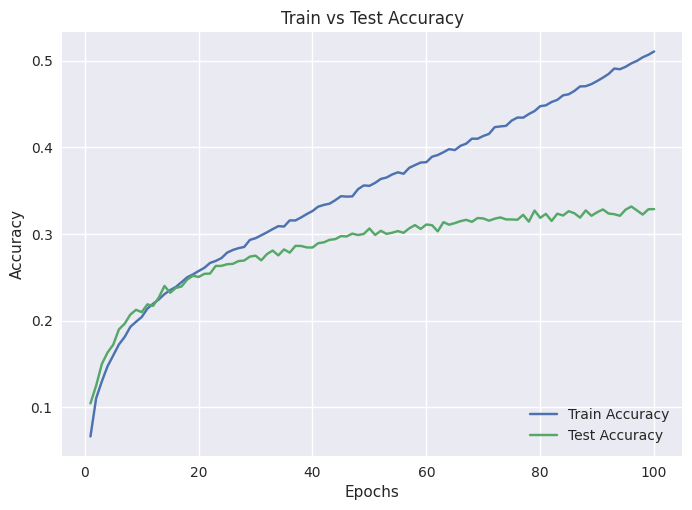

In [14]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [15]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 91.86it/s] 


####  Superclass confusion matrix

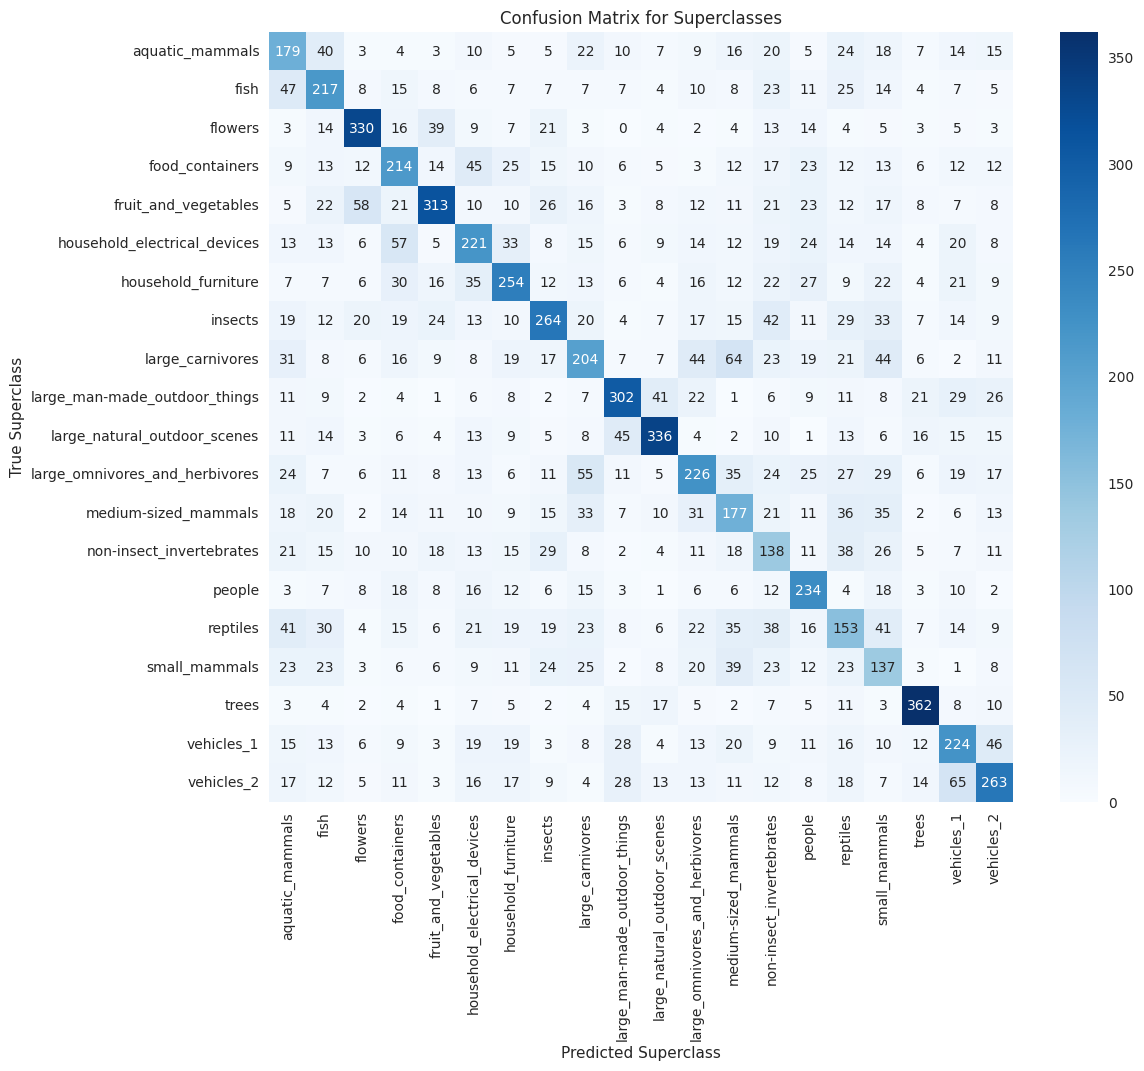

In [16]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

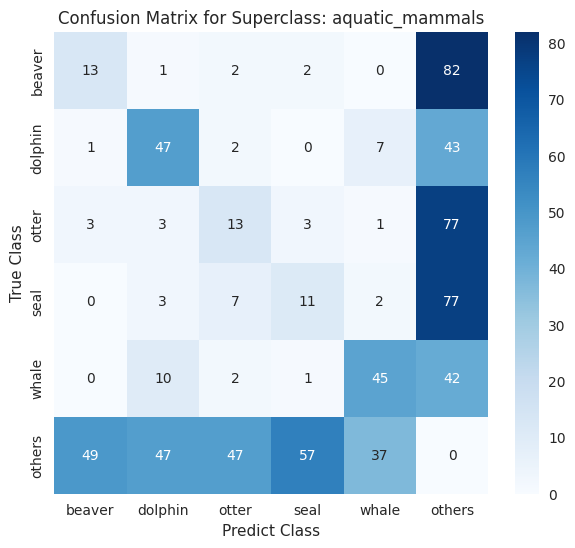

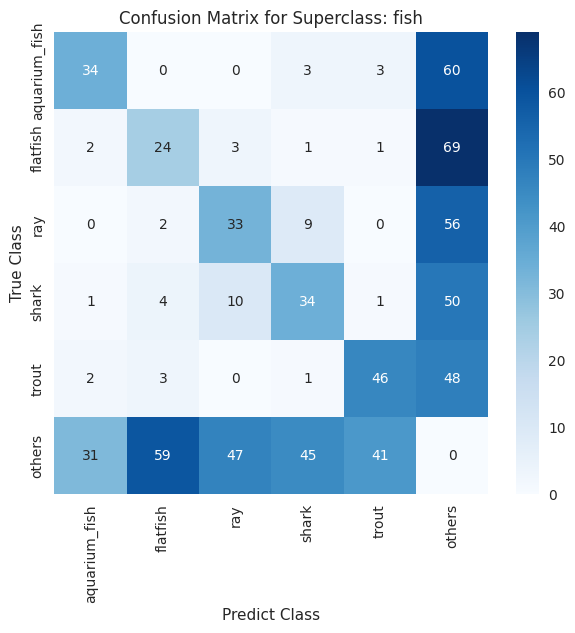

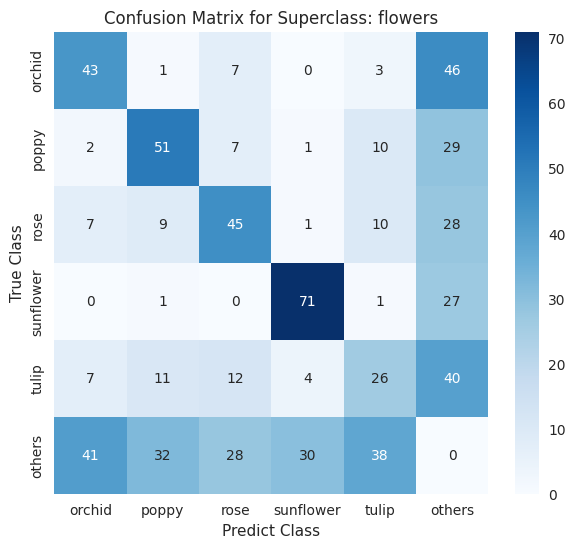

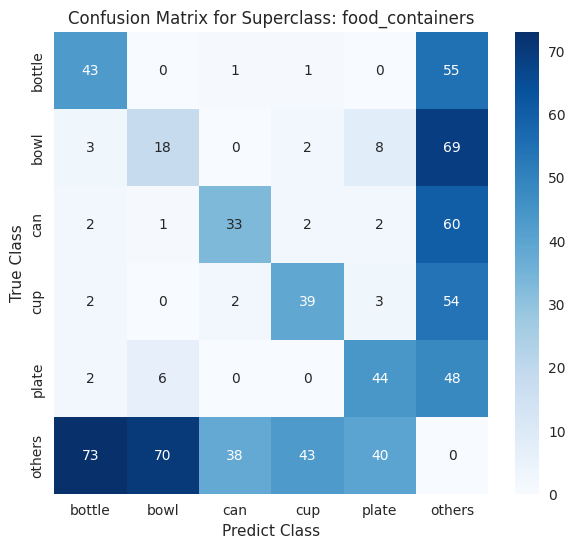

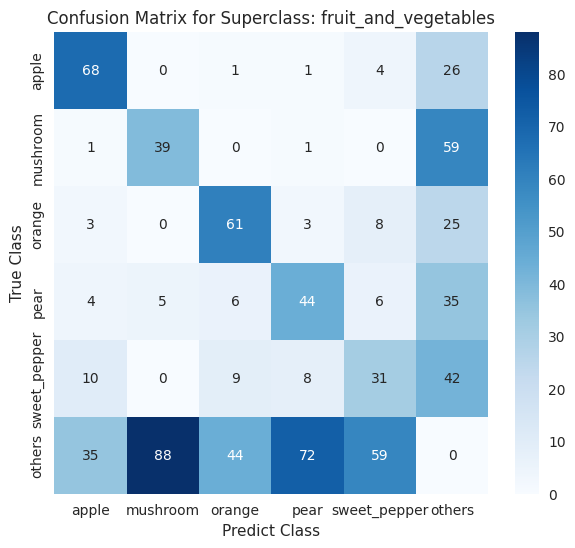

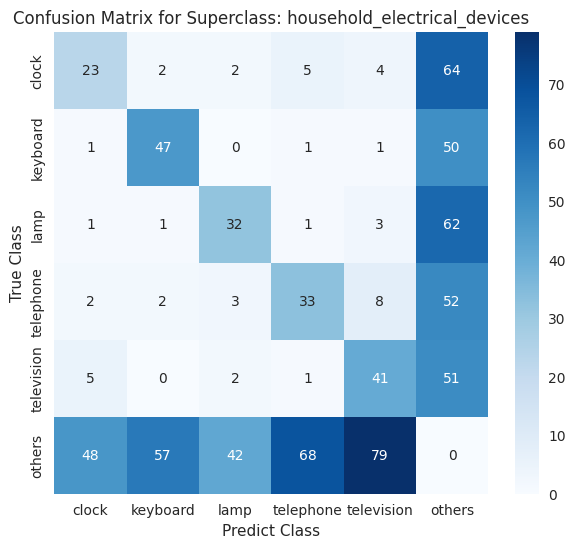

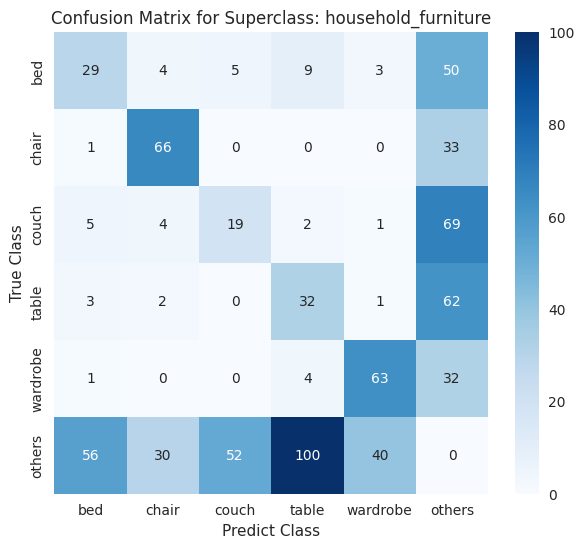

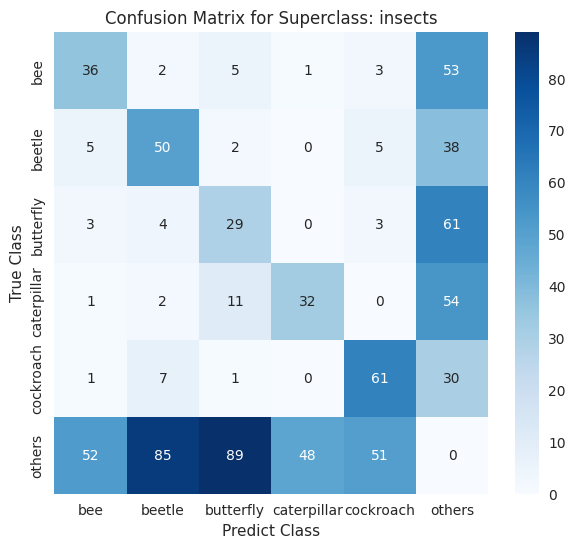

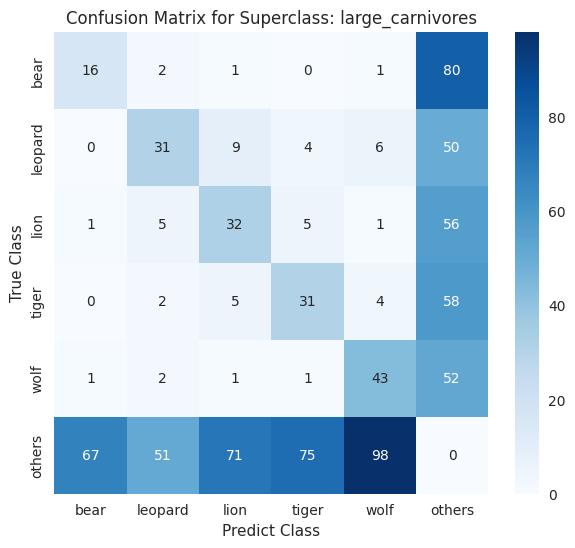

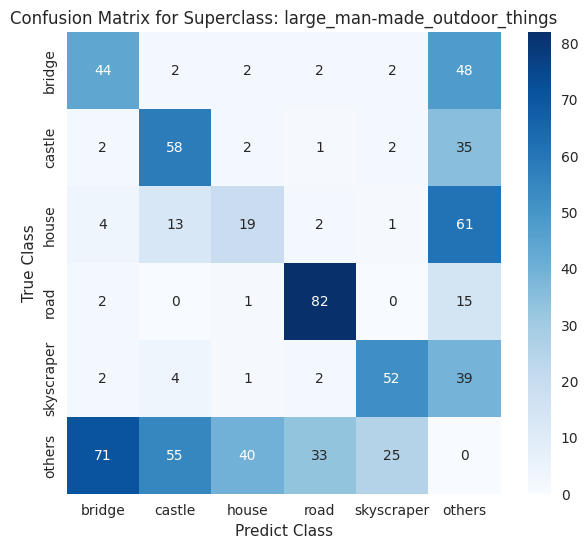

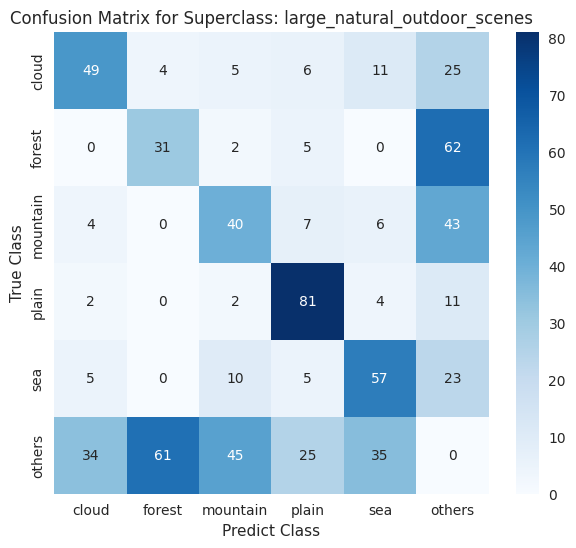

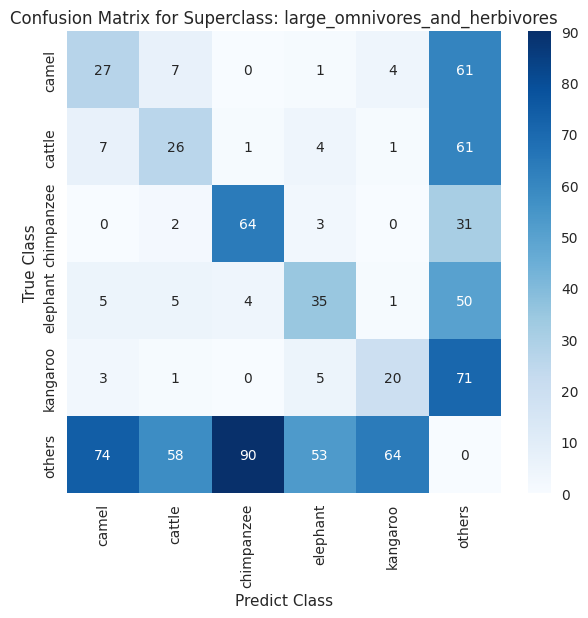

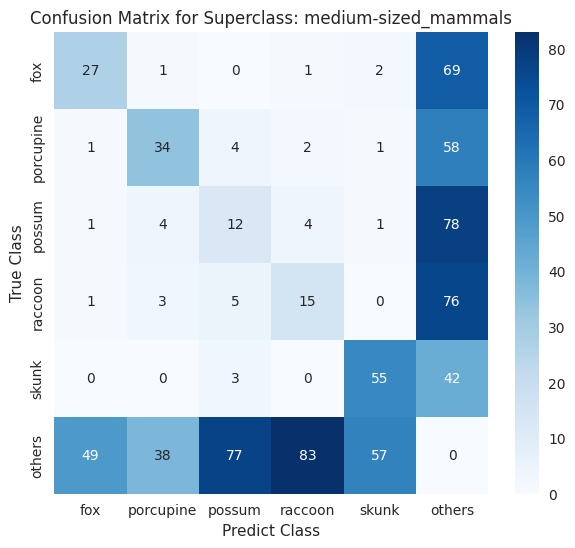

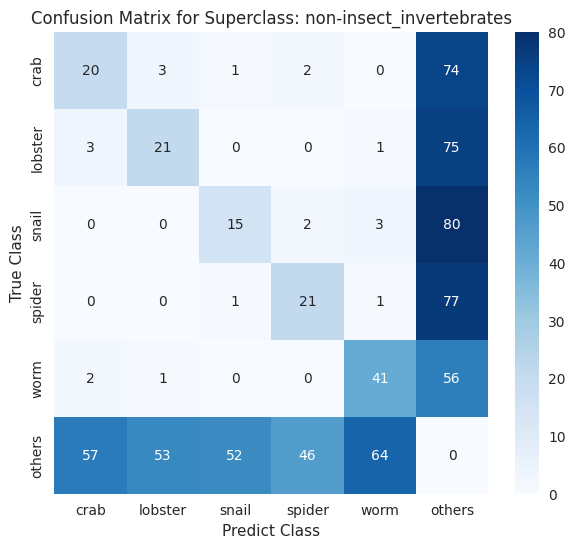

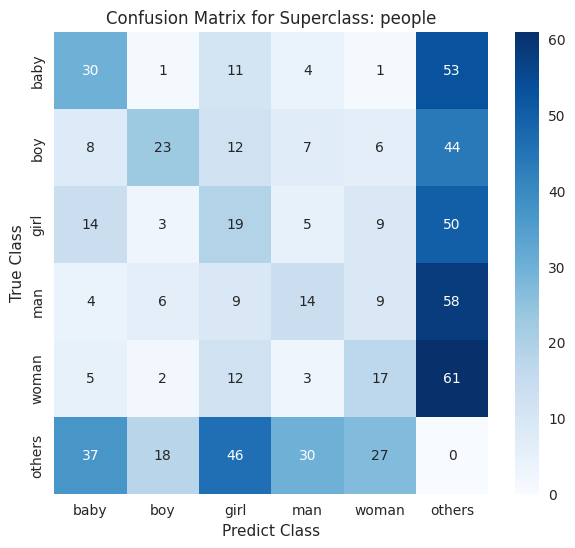

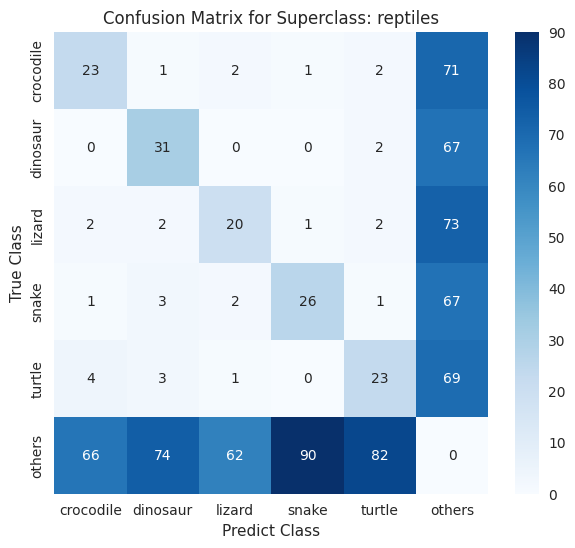

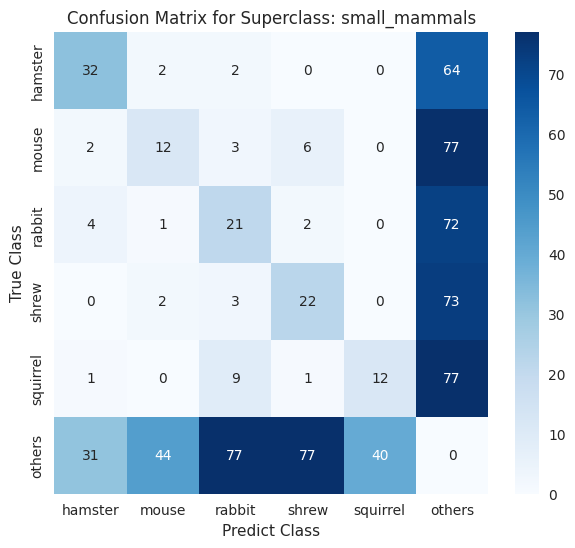

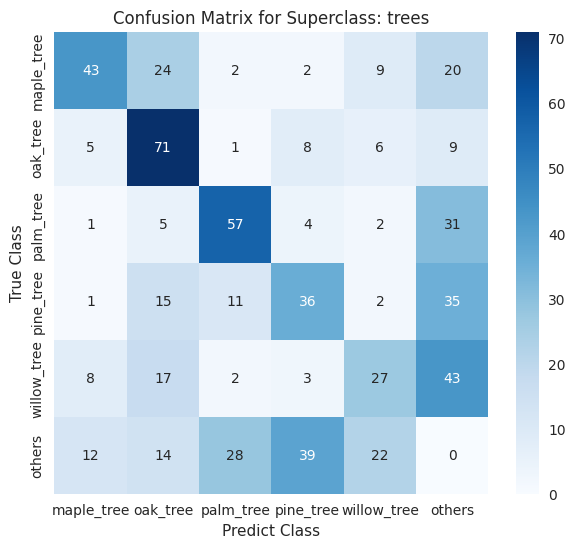

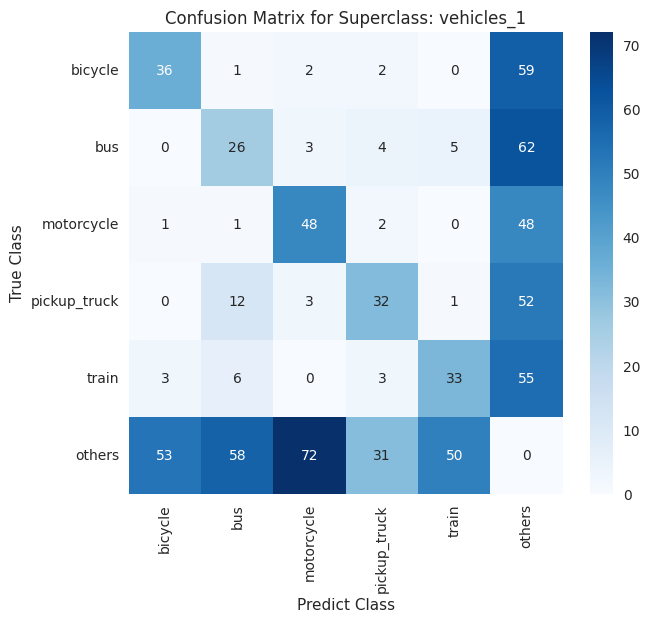

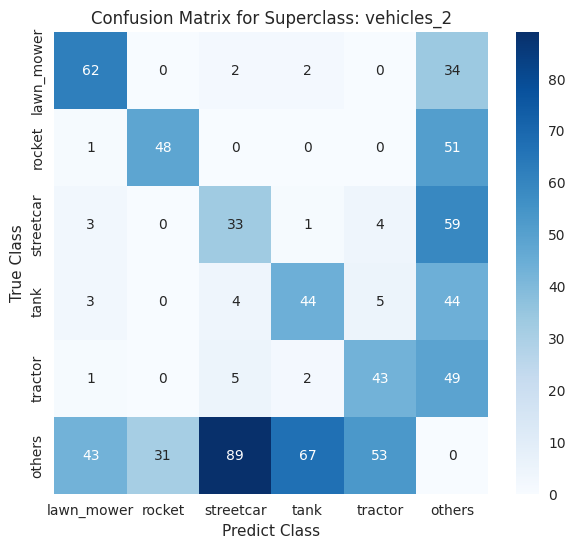

In [17]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [18]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [19]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  9.32 M  
fwd MACs:                                                               1.4637 GMACs
fwd FLOPs:                                                              2.9356 GFLOPS
fwd+bwd MACs:                                                           4.391 GMACs
fwd+bwd FLOPs:                                                          8.8067 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module 